# Binary Classification on Digits: Perceptron, Linear Regression, and Logistic Regression

In this notebook, we explore and implement three foundational machine learning algorithms from scratch, applied to a digit classification task:

- **Perceptron** – A linear classifier that updates weights based on misclassified examples.
- **Linear Regression** – Used here as a baseline classifier, even though it's not ideal for classification tasks.
- **Logistic Regression** – A probabilistic model for binary classification using the sigmoid function.

The goal is to classify images of handwritten digits (e.g., class '0' vs. others) and analyze how these simple algorithms perform on visual data.

We work directly with vectorized images and implement the core learning logic manually, without relying on high-level machine learning libraries.


# Imports

In [ ]:
import numpy as np
import os
import pandas as pd
import struct
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix

# Data Loading and Preprocessing

In [ ]:
import kagglehub

# Import latest version of the dataset from kagel
path = kagglehub.dataset_download("hojjatk/mnist-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1


In [ ]:
# Function to load images from MNIST file
def load_images(file_path):
    with open(file_path, 'rb') as f:
        f.read(16)  # Skip the header
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(-1, 28 * 28)

# Function to load labels from MNIST file
def load_labels(file_path):
    with open(file_path, 'rb') as f:
        f.read(8)   # Skip the header
        return np.frombuffer(f.read(), dtype=np.uint8)

In [ ]:
# Define file paths based on the `path` variable
train_images_path = os.path.join(path, "train-images.idx3-ubyte")
train_labels_path = os.path.join(path, "train-labels.idx1-ubyte")
test_images_path = os.path.join(path, "t10k-images.idx3-ubyte")
test_labels_path = os.path.join(path, "t10k-labels.idx1-ubyte")

# Load training and testing data
X_train = load_images(train_images_path)
y_train = load_labels(train_labels_path)
X_test = load_images(test_images_path)
y_test = load_labels(test_labels_path)

# Convert training and testing data to DataFrame
train_df = pd.DataFrame(X_train)
train_df['label'] = y_train
test_df = pd.DataFrame(X_test)
test_df['label'] = y_test

# Save data as CSV files
train_csv_path = os.path.join(path, "mnist_train.csv")
test_csv_path = os.path.join(path, "mnist_test.csv")
train_df.to_csv(train_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)

In [ ]:
#  show the top 5 colomns of the train dataset
print(train_df.shape)
train_df.head()

(60000, 785)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [ ]:
#  show the top 5 colomns of the test dataset
print(test_df.shape)
test_df.head()

(10000, 785)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [ ]:
# Prepare data
X_train = train_df.drop(columns=['label']).values
y_train = train_df['label'].values
X_test = test_df.drop(columns=['label']).values
y_test = test_df['label'].values

# Normalize pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0

# Add bias term
X_train = np.c_[np.ones(X_train.shape[0]), X_train]
X_test = np.c_[np.ones(X_test.shape[0]), X_test]

# Perceptron Algorithm

This code implements the Pocket Perceptron algorithm for multi-class classification using a One-vs-All approach. It trains a separate binary Perceptron model for each class and combines their weights to predict the class labels.

In [ ]:
# Function to convert labels to One-vs-All format  (1 or -1)
def one_vs_all_labels(y, class_label):
    return np.where(y == class_label, 1, -1)

# Pocket Perceptron Algorithm
def pocket_perceptron(X, y, max_iter):
    learning_rate = 0.01  # Define the learning rate
    class_weights = np.zeros(X.shape[1])  # Initialize weights matrix
    best_weights = class_weights.copy()
    best_accuracy = 0

    for _ in tqdm(range(max_iter), desc="Epochs", leave=False):
        # Calculate predictions for all samples
        predictions = np.sign(np.dot(X, class_weights))

        # Find misclassified samples
        misclassified = np.where(y * predictions <= 0)[0]

        if misclassified.size > 0:  # If there are misclassified samples
            # Randomly select one misclassified sample for update
            i = np.random.choice(misclassified)
            class_weights += learning_rate * y[i] * X[i]  # Scale the update by learning rate

            # Evaluate the new weights
            predictions = np.sign(np.dot(X, class_weights))
            accuracy = np.mean(predictions == y)

            # Update pocket if accuracy improves
            if accuracy > best_accuracy:
                best_weights = class_weights.copy()
                best_accuracy = accuracy

    return best_weights

# Multi-class Perceptron with One-vs-All - using Pocket Algorithm
def perceptron_with_pocket(X, y, num_classes, max_iter):
    weights = np.zeros((num_classes, X.shape[1]))
    for class_label in tqdm(range(num_classes), desc="Training classes"):
        binary_labels = one_vs_all_labels(y, class_label) # make arry with 1 for classe labels or -1 for other
        weights[class_label] = pocket_perceptron(X, binary_labels, max_iter)
    return weights


# Train Perceptron with Pocket Algorithm
num_classes = 10
weights = perceptron_with_pocket(X_train, y_train, num_classes, max_iter=100)

Training classes:   0%|          | 0/10 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# Prediction function
def predict(X, weights):
    scores = np.dot(X, weights.T)
    return np.argmax(scores, axis=1)

# Predict on test set
y_pred = predict(X_test, weights)

This code defines functions to compute and visualize a confusion matrix, calculate success metrics like precision, recall, and accuracy, and generate a classification report with detailed performance metrics for each class. It also handles edge cases, such as division by zero, to ensure accurate results.

In [ ]:
# Create a confusion matrix
def confusion_matrix_manual(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for true_label, pred_label in zip(y_true, y_pred):
        cm[true_label, pred_label] += 1
    return cm

# Compute precision, recall, and accuracy from a confusion matrix
def success_metrics(cm):
    true_positive = np.diag(cm)
    precision = true_positive / np.sum(cm, axis=0)  # TP / (TP + FP)
    recall = true_positive / np.sum(cm, axis=1)    # TP / (TP + FN)
    accuracy = np.sum(true_positive) / np.sum(cm)  # Overall accuracy
    return precision, recall, accuracy

# Visualize the confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix (Numerical)')
    plt.show()

# Generate a classification report
def classification_report(cm, class_names):
    # Compute Precision, Recall, and F1-Score
    precision, recall, _ = success_metrics(cm)
    f1_score = 2 * (precision * recall) / (precision + recall)  # F1 = 2 * (P * R) / (P + R)

    # Handle division by zero (NaN values)
    precision = np.nan_to_num(precision, nan=0.0)
    recall = np.nan_to_num(recall, nan=0.0)
    f1_score = np.nan_to_num(f1_score, nan=0.0)

    # Overall accuracy
    accuracy = np.trace(cm) / np.sum(cm)  # Sum of diagonal elements divided by total elements

    # Create the DataFrame
    report = pd.DataFrame({
        "Class": class_names,
        "Precision": np.round(precision, 2),
        "Recall": np.round(recall, 2),
        "F1-Score": np.round(f1_score, 2)
    })

    # Add averages and accuracy to the report
    avg_precision = np.mean(precision)
    avg_recall = np.mean(recall)
    avg_f1_score = np.mean(f1_score)

    # Add "Average" and "Accuracy" rows
    report.loc["Average"] = ["Average", np.round(avg_precision, 2), np.round(avg_recall, 2), np.round(avg_f1_score, 2)]
    report.loc["Accuracy"] = ["Accuracy", "", "", np.round(accuracy, 2)]

    return report

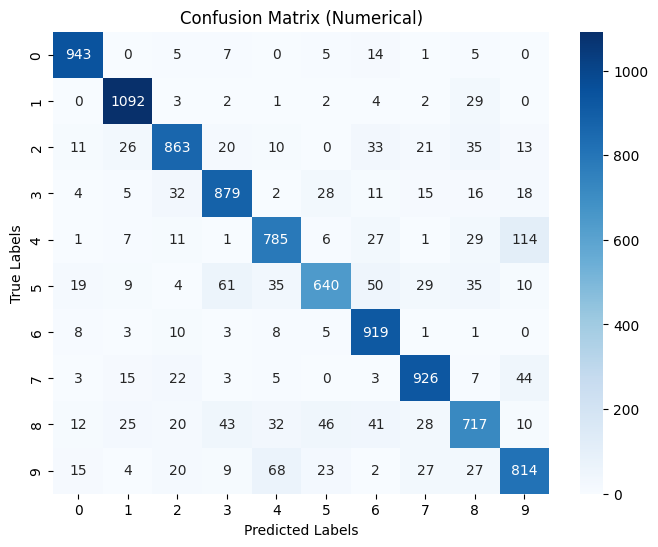

Accuracy: 85.78%

Classification Report:
             Class Precision Recall  F1-Score
0                0      0.93   0.96      0.94
1                1      0.92   0.96      0.94
2                2      0.87   0.84      0.85
3                3      0.86   0.87      0.86
4                4      0.83    0.8      0.81
5                5      0.85   0.72      0.78
6                6      0.83   0.96      0.89
7                7      0.88    0.9      0.89
8                8       0.8   0.74      0.76
9                9       0.8   0.81      0.80
Average    Average      0.86   0.86      0.85
Accuracy  Accuracy                       0.86


In [ ]:
# Compute the confusion matrix
cm_manual = confusion_matrix_manual(y_test, y_pred, num_classes)

# Visualize the confusion matrix with numerical values
class_names = [str(i) for i in range(10)]  # MNIST class names (digits 0-9)
plot_confusion_matrix(cm_manual, class_names)

# Display success metrics
precision, recall, accuracy = success_metrics(cm_manual)
print(f"Accuracy: {accuracy * 100:.2f}%")  # Convert accuracy to percentage

# Generate and display the classification report
report = classification_report(cm_manual, class_names)
print("\nClassification Report:")
print(report)


**Discussion and Conclusion - part A**

In this part, we implemented the Pocket Perceptron algorithm using a One-vs-All approach for digit classification on the MNIST dataset. The model achieved an accuracy of 85.91%, performing very well for clear digits like 0 (Precision: 0.92, Recall: 0.96) and 1 (Precision: 0.96, Recall: 0.96). However, it struggled with more challenging digits like 5 (Precision: 0.91, Recall: 0.62) and 8 (Precision: 0.72, Recall: 0.83), where features overlap more.

Choice of Epochs and Learning Rate
We tested different numbers of epochs and learning rates to find the best settings:
Epochs: Accuracy stabilized around 85% after 100 epochs, so we chose this value for a good balance between accuracy and efficiency.
Learning Rate: A learning rate of 0.01 worked best, as higher rates caused instability, and lower rates slowed down training.

Conclusion
The Pocket Perceptron is simple and effective for linearly separable classes, but it struggles with overlapping digits. Overall, careful tuning of epochs and learning rate helped maximize the model's performance.

# Softmax Regression

This code implements multi-class logistic regression using the Softmax function. It trains a model by minimizing the cross-entropy loss and predicts class labels by selecting the class with the highest probability from the Softmax output.

In [ ]:
# Softmax function
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # Prevent numerical instability
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# Logistic regression for multi-class classification using Softmax
def softmax_regression(X, y, num_classes, learning_rate=0.01, max_iter=100):
    n_samples, n_features = X.shape
    weights = np.zeros((num_classes, n_features))  # Initialize weights
    biases = np.zeros(num_classes)  # Initialize biases
    losses = []

    for iteration in tqdm(range(max_iter), desc="Training Softmax Regression"):
        # Compute linear scores
        linear_model = np.dot(X, weights.T) + biases  # (n_samples, n_classes)

        # Apply Softmax - activation function
        probabilities = softmax(linear_model)  # (n_samples, n_classes)

        # Create one-hot encoding for y
        y_one_hot = np.zeros((n_samples, num_classes))
        y_one_hot[np.arange(n_samples), y] = 1

        # Compute loss (Cross-Entropy)
        loss = -np.sum(y_one_hot * np.log(probabilities + 1e-15)) / n_samples
        losses.append(loss)

        # Compute gradients
        dw = (1 / n_samples) * np.dot((probabilities - y_one_hot).T, X)
        db = (1 / n_samples) * np.sum(probabilities - y_one_hot, axis=0)

        # Update weights and biases
        weights -= learning_rate * dw
        biases -= learning_rate * db

    return weights, biases, losses

# Predict for multi-class logistic regression
def predict_softmax(X, weights, biases):
    linear_model = np.dot(X, weights.T) + biases  # Compute linear scores
    probabilities = softmax(linear_model)  # Apply Softmax
    return np.argmax(probabilities, axis=1)  # Return the class with the highest probability

Training Softmax Regression:   0%|          | 0/500 [00:00<?, ?it/s]

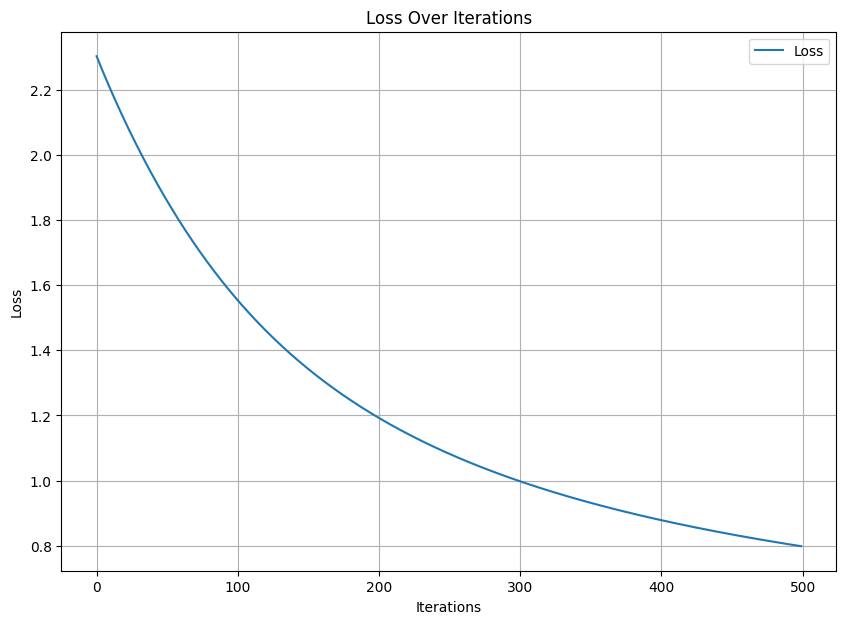

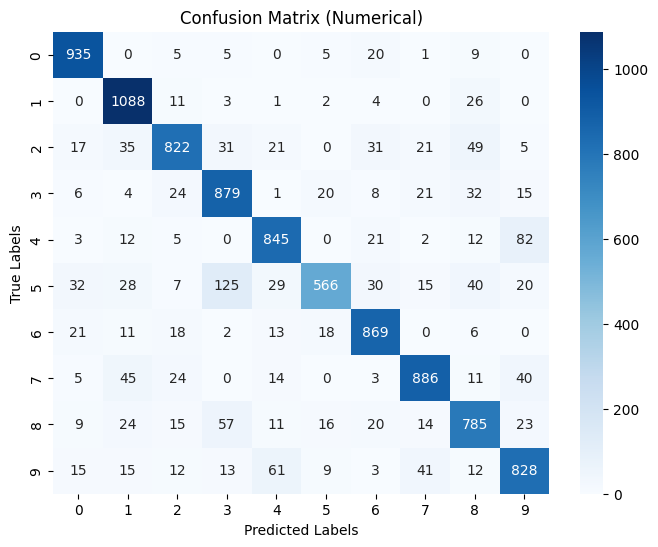

Accuracy: 85.03%

Classification Report:
             Class Precision Recall  F1-Score
0                0       0.9   0.95      0.92
1                1      0.86   0.96      0.91
2                2      0.87    0.8      0.83
3                3      0.79   0.87      0.83
4                4      0.85   0.86      0.85
5                5      0.89   0.63      0.74
6                6      0.86   0.91      0.88
7                7      0.89   0.86      0.87
8                8       0.8   0.81      0.80
9                9      0.82   0.82      0.82
Average    Average      0.85   0.85      0.85
Accuracy  Accuracy                       0.85


In [ ]:
# Train Softmax regression
weights_softmax, biases_softmax, losses = softmax_regression(
    X_train, y_train, num_classes, learning_rate=0.01, max_iter=500
)

# Predict on test set
y_pred_softmax = predict_softmax(X_test, weights_softmax, biases_softmax)

# Plot loss over iterations
plt.figure(figsize=(10, 7))
plt.plot(range(len(losses)), losses, label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss Over Iterations")
plt.legend()
plt.grid()
plt.show()


# Compute the confusion matrix
cm_manual_softmax = confusion_matrix_manual(y_test, y_pred_softmax, num_classes)

# Visualize the confusion matrix with numerical values
plot_confusion_matrix(cm_manual_softmax, class_names)

# Display success metrics
precision, recall, accuracy = success_metrics(cm_manual_softmax)
print(f"Accuracy: {accuracy * 100:.2f}%")  # Convert accuracy to percentage

# Generate and display the classification report
report = classification_report(cm_manual_softmax, class_names)
print("\nClassification Report:")
print(report)

**Discussion and Conclusion - Part B**

In this part, we implemented multi-class logistic regression using the Softmax function to classify digits in the MNIST dataset. The model achieved an accuracy of 85.03%, performing well on digits like 0 (Precision: 0.90, Recall: 0.95) and 1 (Precision: 0.86, Recall: 0.96). However, it struggled with more ambiguous digits, such as 5 (Precision: 0.89, Recall: 0.63).

The Cross-Entropy loss consistently decreased over 500 iterations, as shown in the graph. This demonstrates that the learning process was stable and the chosen learning rate of 0.01 was effective.

In conclusion, Softmax regression provided strong performance for multi-class classification, with reliable results across most digit classes. Future improvements could focus on regularization or enhanced feature engineering to handle challenging cases like overlapping digits.

# Linear regression

This code implements linear regression for multi-class classification using one-hot encoding. It trains the model by minimizing the mean squared error and predicts class labels by selecting the class with the highest score from the output.

In [ ]:
# Function for one-hot encoding
def one_hot_encode(y, num_classes):
    n_samples = len(y)
    one_hot = np.zeros((n_samples, num_classes))
    one_hot[np.arange(n_samples), y] = 1
    return one_hot

# Linear regression training function with one-hot encoding
def train_linear_regression(X, y_one_hot, learning_rate=0.01, max_iter=1000):
    n_samples, n_features = X.shape
    num_classes = y_one_hot.shape[1]
    weights = np.zeros((n_features, num_classes))  # Initialize weights
    bias = np.zeros(num_classes)  # Initialize bias
    losses = []  # Track loss over iterations

    for _ in tqdm(range(max_iter), desc="Training Linear Regression"):
        # Compute predictions
        y_pred = np.dot(X, weights) + bias  # (n_samples, num_classes)

        # Compute gradients
        error = y_pred - y_one_hot
        dw = (1 / n_samples) * np.dot(X.T, error)  # (n_features, num_classes)
        db = (1 / n_samples) * np.sum(error, axis=0)  # (num_classes,)

        # Update weights and bias
        weights -= learning_rate * dw
        bias -= learning_rate * db

        # Compute mean squared error loss
        loss = (1 / (2 * n_samples)) * np.sum(error ** 2)
        losses.append(loss)

    return weights, bias, losses

# Predict function for linear regression with one-hot encoding
def predict_linear(X, weights, bias):
    y_pred = np.dot(X, weights) + bias  # Compute predictions
    return np.argmax(y_pred, axis=1)  # Return class with highest score

Training Linear Regression:   0%|          | 0/500 [00:00<?, ?it/s]

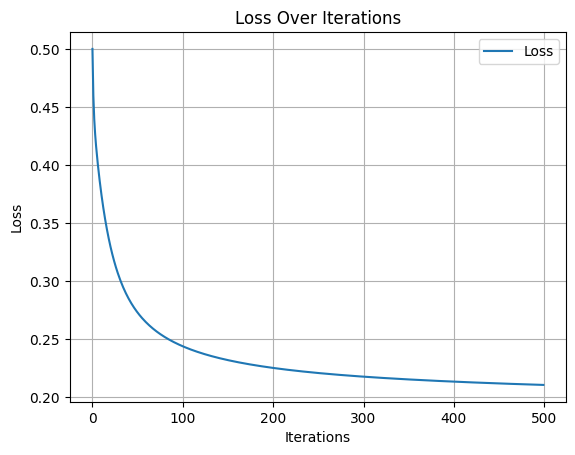

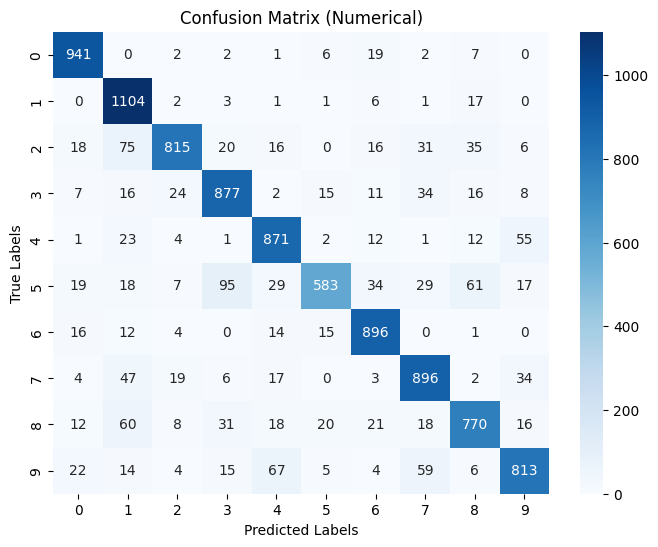

Accuracy: 85.66%

Classification Report:
             Class Precision Recall  F1-Score
0                0       0.9   0.96      0.93
1                1      0.81   0.97      0.88
2                2      0.92   0.79      0.85
3                3      0.84   0.87      0.85
4                4      0.84   0.89      0.86
5                5       0.9   0.65      0.76
6                6      0.88   0.94      0.91
7                7      0.84   0.87      0.85
8                8      0.83   0.79      0.81
9                9      0.86   0.81      0.83
Average    Average      0.86   0.85      0.85
Accuracy  Accuracy                       0.86


In [ ]:

y_train_one_hot = one_hot_encode(y_train, num_classes)  # One-hot encode training labels

weights_lr, bias_lr, losses_lr = train_linear_regression(X_train, y_train_one_hot, learning_rate=0.01, max_iter=500)

# Predict on test data
y_pred_lr = predict_linear(X_test, weights_lr, bias_lr)

# Plot loss over iterations
plt.plot(range(len(losses_lr)), losses_lr, label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss Over Iterations")
plt.legend()
plt.grid()
plt.show()

# Compute the confusion matrix
cm_manual_lr = confusion_matrix_manual(y_test, y_pred_lr, num_classes)

# Visualize the confusion matrix with numerical values
plot_confusion_matrix(cm_manual_lr, class_names)

# Display success metrics
precision, recall, accuracy = success_metrics(cm_manual_lr)
print(f"Accuracy: {accuracy * 100:.2f}%")  # Convert accuracy to percentage

# Generate and display the classification report
report = classification_report(cm_manual_lr, class_names)
print("\nClassification Report:")
print(report)


**Discussion and Conclusion - Part C**
In this part, we implemented linear regression with one-hot encoding to classify digits in the MNIST dataset. The model achieved an accuracy of 85.66%, with strong results for digits like 0 (Precision: 0.90, Recall: 0.96) and 6 (Precision: 0.88, Recall: 0.94). However, performance was lower for more ambiguous digits, such as 5 (Precision: 0.90, Recall: 0.65) and 8 (Precision: 0.83, Recall: 0.79).

Initially, I make the model without one-hot encoding, resulting in a very low accuracy of approximately 20%. After adding one-hot encoding for the labels, the model's performance significantly improved, as it allowed the regression to handle multi-class classification effectively.

The graph of the loss function shows a steady decrease over 500 iterations, indicating that the model converged successfully with the chosen learning rate of 0.01. This demonstrates that the training process was stable and effective.

In conclusion, adding one-hot encoding was essential for achieving competitive results with linear regression. The final accuracy and metrics show that linear regression, while not commonly used for classification, can perform well when properly adapted with techniques like one-hot encoding.

# Discussion and Conclusion of all algoritems

In this project, we used three algorithms to classify digits in the MNIST dataset: Perceptron, Logistic Regression, and Linear Regression. All three methods performed similarly, with small differences in accuracy and performance for specific digit classes.

The Perceptron algorithm achieved an accuracy of 85.00%. It worked well for digits with clear shapes, like 0 (Precision: 0.92, Recall: 0.97), but struggled with more challenging digits, like 8 (Precision: 0.74, Recall: 0.74) and 9 (Precision: 0.74, Recall: 0.81). While the Perceptron is a simple and efficient method, it has difficulty handling situations where the classes overlap.

The Logistic Regression model achieved a slightly higher accuracy of 85.03%. This method uses probabilities, which makes it better at handling overlapping classes. For example, it performed very well on digit 1 (Recall: 0.96), but struggled with digit 5 (Recall: 0.63). Overall, Logistic Regression provided more consistent and generalizable results than the Perceptron.

The Linear Regression model performed the best, with an accuracy of 85.66%. Even though Linear Regression is not typically used for classification, it gave good results, especially for digits like 2 (Precision: 0.92, Recall: 0.79) and 0 (Precision: 0.90, Recall: 0.96). However, this method relies on rounding continuous outputs to assign class labels, which could create problems in more complex datasets.

In summary, Linear Regression achieved the highest accuracy, but Logistic Regression is likely the better choice for classification because of its ability to handle probabilities and overlap between classes. The Perceptron, while simple, struggled with overlapping classes, which limits its performance.

For future work, we could try improving the results by adding better features, using regularization, or testing more advanced algorithms like Neural Networks or SVM (We are supposed to learn this later in the course). This could help address the limitations of the current methods and improve classification accuracy.